In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.init as init

In [2]:
ban_data=pd.read_csv(r"C:\Users\sriva\OneDrive\Documents\GitHub\FinalProject_BDL\Bangalore,India 2021-10-30 to 2024-04-13.csv")
ban_data.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"Bangalore,India",2021-10-30,28.9,20.0,23.5,30.6,20.0,23.8,20.6,85.0,...,13.5,6,NaN,2021-10-30T06:12:43,2021-10-30T17:53:42,0.82,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"43296099999,VOBG,42705699999,VOBL,43302599999,..."
1,"Bangalore,India",2021-10-31,26.8,20.0,23.0,28.5,20.0,23.0,20.3,86.0,...,14.9,7,NaN,2021-10-31T06:12:59,2021-10-31T17:53:21,0.85,"Rain, Partially cloudy",Partly cloudy throughout the day with afternoo...,rain,"43296099999,VOBG,42705699999,VOBL,43302599999,..."
2,"Bangalore,India",2021-11-01,26.8,20.9,22.8,28.1,20.9,22.9,20.7,88.3,...,8.2,3,NaN,2021-11-01T06:13:16,2021-11-01T17:53:00,0.88,"Rain, Partially cloudy",Partly cloudy throughout the day with afternoo...,rain,"43296099999,VOBG,42705699999,VOBL,43302599999,..."
3,"Bangalore,India",2021-11-02,26.8,20.0,22.2,28.3,20.0,22.3,19.9,87.8,...,12.3,7,NaN,2021-11-02T06:13:33,2021-11-02T17:52:41,0.91,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"43296099999,VOBG,42705699999,VOBL,43302599999,..."
4,"Bangalore,India",2021-11-03,25.9,20.0,22.2,25.9,20.0,22.2,19.8,87.0,...,5.8,3,NaN,2021-11-03T06:13:51,2021-11-03T17:52:22,0.95,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"43296099999,VOBG,42705699999,VOBL,43302599999,..."


In [3]:
ban_data.shape

(897, 33)

In [4]:
data_T=ban_data[['datetime','temp']]

In [5]:
data_T['datetime']=pd.to_datetime(data_T['datetime'],format='%Y-%m-%d')

C:\Users\sriva\AppData\Local\Temp\ipykernel_3156\173673238.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_T['datetime']=pd.to_datetime(data_T['datetime'],format='%Y-%m-%d')


In [6]:
from copy import deepcopy as dc
def prep_df_lstm(df,n_steps):
    df=dc(df)
    df.set_index('datetime',inplace=True)
    for i in range(1,n_steps+1):
        df['t-'+str(i)]=df['temp'].shift(i)
    df.dropna(inplace=True)
    return df


In [7]:
time_period=5
shifted_df=prep_df_lstm(data_T,time_period)
shifted_df.head()

,temp,t-1,t-2,t-3,t-4,t-5
datetime,,,,,,
2021-11-04,23.1,22.2,22.2,22.8,23.0,23.5
2021-11-05,21.7,23.1,22.2,22.2,22.8,23.0
2021-11-06,23.1,21.7,23.1,22.2,22.2,22.8
2021-11-07,21.6,23.1,21.7,23.1,22.2,22.2
2021-11-08,20.9,21.6,23.1,21.7,23.1,22.2


In [8]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
df_np=shifted_df.to_numpy()


In [10]:
#inputes :t-1 to t-7
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(-1,1))
df_np=scaler.fit_transform(df_np)


In [11]:
X=df_np[:,1:]
y=df_np[:,0]
X=dc(np.flip(X,axis=1))
split_index_1=int(0.9*len(X))
split_index_2=int(0.99*len(X))


In [12]:
X_train=X[:split_index_1]
y_train=y[:split_index_1]
X_test=X[split_index_1:split_index_2]
y_test=y[split_index_1:split_index_2]
X_val=X[split_index_2:]
y_val=y[split_index_2:]

In [13]:
X_train=X_train.reshape(-1,time_period,1) #Requirement for LSTM in pytorch
X_test=X_test.reshape(-1,time_period,1)
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)
X_val=X_val.reshape(-1,time_period,1)
y_val=y_val.reshape(-1,1)

In [14]:
#Put in pytorch tensors
X_train=torch.tensor(X_train).float().to(device)
y_train=torch.tensor(y_train).float().to(device)
X_test=torch.tensor(X_test).float().to(device)
y_test=torch.tensor(y_test).float().to(device)
X_val=torch.tensor(X_val).float().to(device)
y_val=torch.tensor(y_val).float().to(device)

In [15]:
from torch.utils.data import Dataset,DataLoader
class WeatherDataset(Dataset):
    def __init__(self,X,y):
        self.X=X
        self.y=y
    def __len__(self):
        return len(self.X)
    def __getitem__(self,idx):
        return self.X[idx],self.y[idx]
train_dataset=WeatherDataset(X_train,y_train)
test_dataset=WeatherDataset(X_test,y_test)

In [16]:
batch_size=32
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [17]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(LSTM,self).__init__()
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.lstm=nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        self.fc=nn.Linear(hidden_size,output_size)
    def forward(self,x):
        h0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
        c0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
        out,_=self.lstm(x,(h0,c0))
        out=self.fc(out[:,-1,:])
        return out
model=LSTM(1,128,2,1).to(device)
model.to(device)

LSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [18]:
loss_train=[]
def train_epoch():
    model.train(True)
    print(f'Epoch {epoch+1}')
    running_loss=0
    for batch_index,batch in enumerate(train_loader):
        X_batch,y_batch=batch
        output=model(X_batch)
        loss=criterion(output,y_batch)
        running_loss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_index%100==99:
            avg_loss=running_loss/100
            print(f'Batch : {batch_index+1} Loss : {avg_loss}')
            loss_train.append(avg_loss)
            plt.plot(loss_train)
            plt.show()
            running_loss=0

In [19]:
def validate_epoch():
    model.train(False)
    running_loss=0
    for batch_index,batch in enumerate(test_loader):
        X_batch,y_batch=batch
        with torch.no_grad():
            output=model(X_batch)
            loss=criterion(output,y_batch)
            running_loss+=loss.item()
    avg_loss=running_loss/len(test_loader)
    print(f'Validation Loss : {avg_loss}')

In [20]:
lr=1e-3
num_epochs=60
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=lr)
scheduler=lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)
for epoch in range(num_epochs):
    train_epoch()
    validate_epoch()
    scheduler.step()

Epoch 1
Validation Loss : 0.1280273242543141
Epoch 2
Validation Loss : 0.040072608118255935
Epoch 3
Validation Loss : 0.027433808892965317
Epoch 4
Validation Loss : 0.033800087248285614
Epoch 5
Validation Loss : 0.03181141677002112
Epoch 6
Validation Loss : 0.02579819659392039
Epoch 7
Validation Loss : 0.02931918328007062
Epoch 8
Validation Loss : 0.02025661027679841
Epoch 9
Validation Loss : 0.02258746636410554
Epoch 10
Validation Loss : 0.02049656833211581
Epoch 11
Validation Loss : 0.01746912548939387
Epoch 12
Validation Loss : 0.01786688280602296
Epoch 13
Validation Loss : 0.018150280229747295
Epoch 14
Validation Loss : 0.017944790112475555
Epoch 15
Validation Loss : 0.016704014192024868
Epoch 16
Validation Loss : 0.01899474176267783
Epoch 17
Validation Loss : 0.01709100076307853
Epoch 18
Validation Loss : 0.016796328437825043
Epoch 19
Validation Loss : 0.017358177651961643
Epoch 20
Validation Loss : 0.01659549493342638
Epoch 21
Validation Loss : 0.016507475326458614
Epoch 22
Valid

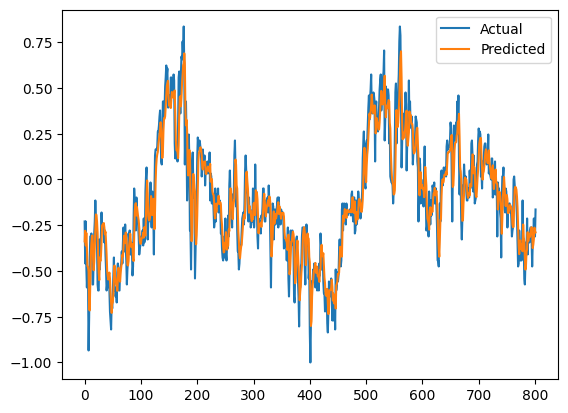

In [21]:
with torch.no_grad():
    predicted=model(X_train).to('cpu').numpy()

plt.plot(y_train.to('cpu').numpy(),label='Actual')
plt.plot(predicted,label='Predicted')
plt.legend()
plt.show()

In [22]:
train_predictions=predicted.flatten()
dummies=np.zeros((X_train.to('cpu').shape[0],time_period+1))
dummies[:,0]=train_predictions
dummies=scaler.inverse_transform(dummies)
train_predictions=dc(dummies[:,0])
train_predictions

array([22.43893027, 22.79054382, 22.2985699 , 22.7161971 , 22.22387995,
       21.60673966, 21.59320945, 21.42935618, 20.19376704, 20.13358263,
       21.11803113, 21.98266382, 22.37237143, 22.62170758, 22.6307702 ,
       21.87627678, 21.47408809, 21.7461027 , 22.29426356, 22.75704461,
       23.33362117, 23.32180473, 23.09253102, 22.7217111 , 21.90058884,
       21.37449725, 21.14488685, 21.89852257, 21.77902744, 21.95620931,
       22.40449845, 22.97133776, 22.98177111, 23.02801736, 23.04786038,
       22.90421208, 22.67401594, 22.75994568, 22.42205559, 21.99490511,
       21.44723527, 21.28290498, 21.16404541, 21.31479313, 21.39656233,
       21.18874542, 20.73498282, 20.37092909, 20.05234972, 20.35280458,
       20.40780677, 20.68098813, 21.12019375, 21.63173236, 21.3090768 ,
       21.19075279, 20.99324616, 20.99022401, 20.78710611, 21.19876664,
       21.55629505, 21.41942113, 21.1921177 , 21.0922978 , 21.38808272,
       21.58320422, 21.72481715, 21.99370018, 21.92634089, 22.22

In [23]:
#do the same for y_train
dummies=np.zeros((X_train.to('cpu').shape[0],time_period+1))
dummies[:,0]=y_train.to('cpu').numpy().flatten()
dummies=scaler.inverse_transform(dummies)
new_y_train=dc(dummies[:,0])    
new_y_train

array([23.10000003, 21.70000007, 23.10000003, 21.6       , 20.89999993,
       21.49999994, 21.10000005, 18.79999989, 19.90000003, 21.79999995,
       22.60000008, 22.60000008, 22.69999996, 22.50000002, 21.00000017,
       21.00000017, 21.90000001, 22.69999996, 23.10000003, 23.80000002,
       23.2       , 22.80000003, 22.30000008, 21.00000017, 20.80000005,
       20.80000005, 22.50000002, 21.49999994, 22.00000007, 22.69999996,
       23.40000004, 22.90000009, 22.99999997, 22.99999997, 22.69999996,
       22.39999996, 22.80000003, 22.00000007, 21.49999994, 20.80000005,
       21.00000017, 20.89999993, 21.30000018, 21.30000018, 20.80000005,
       20.10000015, 19.80000015, 19.50000014, 20.40000016, 20.20000004,
       20.70000017, 21.30000018, 21.90000001, 20.80000005, 20.89999993,
       20.59999992, 20.80000005, 20.40000016, 21.40000006, 21.70000007,
       21.10000005, 20.80000005, 20.80000005, 21.49999994, 21.6       ,
       21.70000007, 22.09999995, 21.70000007, 22.39999996, 22.90

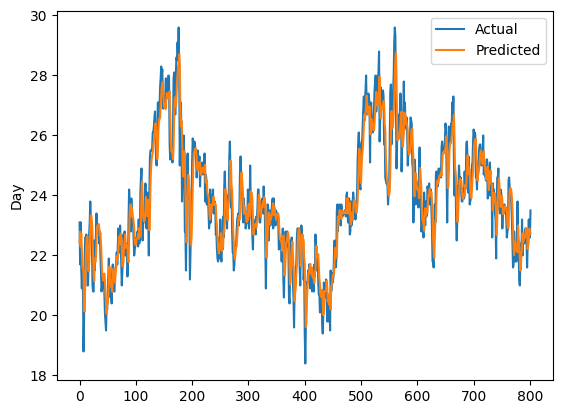

In [24]:
plt.plot(new_y_train,label='Actual')
plt.plot(train_predictions,label='Predicted')
plt.ylabel('Day')
plt.legend()
plt.show()

In [25]:
#Do for test
test_predictions=model(X_test).detach().to('cpu').numpy().flatten()
dummies=np.zeros((X_test.to('cpu').shape[0],time_period+1))
dummies[:,0]=test_predictions
dummies=scaler.inverse_transform(dummies)
test_predictions=dc(dummies[:,0])
test_predictions

array([23.14313543, 23.25974948, 23.15185609, 23.19416014, 23.17311474,
       23.24757308, 23.4851097 , 23.85256216, 24.08456797, 24.09950391,
       23.95199121, 24.10289791, 23.66695768, 23.32075651, 23.05909925,
       23.17994493, 23.20226198, 23.94748272, 24.48525322, 24.93309783,
       25.1960146 , 24.76961452, 24.62839122, 24.66456758, 24.92463895,
       25.25579298, 25.39507903, 24.99411973, 24.42379988, 24.15667226,
       24.13212932, 24.27875836, 24.13444865, 24.09940183, 24.55797784,
       24.99944198, 25.26681216, 25.62677697, 26.17381289, 26.55144755,
       26.86890706, 26.99052845, 26.60852764, 25.64615605, 25.20001007,
       25.36742778, 25.46163688, 25.42602994, 25.68282938, 25.96404805,
       26.54899005, 27.05350359, 27.40522022, 27.61942174, 27.80328509,
       28.05405051, 28.03995019, 27.80200162, 27.72112394, 27.77026727,
       28.17294971, 28.51953156, 28.52025256, 28.04298506, 27.90692667,
       27.85698926, 27.76389902, 27.17764519, 27.14017323, 27.45

In [26]:
dummies=np.zeros((X_test.to('cpu').shape[0],time_period+1))
dummies[:,0]=y_test.to('cpu').numpy().flatten()
dummies=scaler.inverse_transform(dummies)
new_y_test=dc(dummies[:,0])
new_y_test

array([23.29999998, 22.99999997, 23.2       , 23.10000003, 23.29999998,
       23.70000004, 24.19999999, 24.30000001, 24.10000002, 23.80000002,
       24.30000001, 23.2       , 22.99999997, 22.80000003, 23.29999998,
       23.2       , 24.69999999, 24.99999999, 25.40000002, 25.49999999,
       24.30000001, 24.59999999, 24.80000001, 25.29999996, 25.70000002,
       25.59999996, 24.59999999, 23.89999999, 24.00000001, 24.19999999,
       24.5       , 24.00000001, 24.10000002, 25.10000001, 25.49999999,
       25.59999996, 26.09999991, 26.90000005, 27.09999999, 27.4       ,
       27.29999993, 26.30000004, 24.69999999, 24.99999999, 25.8       ,
       25.70000002, 25.49999999, 26.09999991, 26.39999992, 27.4       ,
       27.80000007, 27.99999983, 28.10000007, 28.29999983, 28.70000008,
       28.29999983, 27.80000007, 27.99999983, 28.19999995, 29.09999997,
       29.3000001 , 28.79999996, 27.69999982, 28.19999995, 28.19999995,
       27.99999983, 26.69999992, 27.50000006, 28.19999995, 28.29

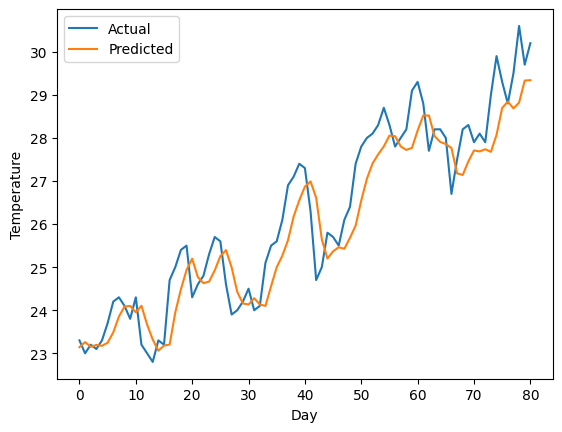

In [27]:
plt.plot(new_y_test,label='Actual')
plt.plot(test_predictions,label='Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.legend()
plt.show()

In [28]:
error=test_predictions-new_y_test
mean_arr=np.mean(error)
print(f'Mean Error : {mean_arr}')

Mean Error : -0.3338328704881814


In [29]:
#Now validation of the model:
with torch.no_grad():
    predicted_val=model(X_val).to('cpu').numpy()
dummies=np.zeros((X_val.to('cpu').shape[0],time_period+1))
dummies[:,0]=predicted_val.flatten()
dummies=scaler.inverse_transform(dummies)
val_predictions=dc(dummies[:,0])
val_predictions   

array([29.47830381, 29.64404301, 29.70150851, 29.75082527, 29.60841572,
       29.11880112, 28.85247776, 28.22331614, 27.93253056])

In [30]:
dummies=np.zeros((X_val.to('cpu').shape[0],time_period+1))
dummies[:,0]=y_val.to('cpu').numpy().flatten()
dummies=scaler.inverse_transform(dummies)
new_y_val=dc(dummies[:,0])
new_y_val

array([30.39999987, 30.29999999, 30.39999987, 29.90000011, 28.89999985,
       29.09999997, 27.80000007, 28.10000007, 29.00000009])

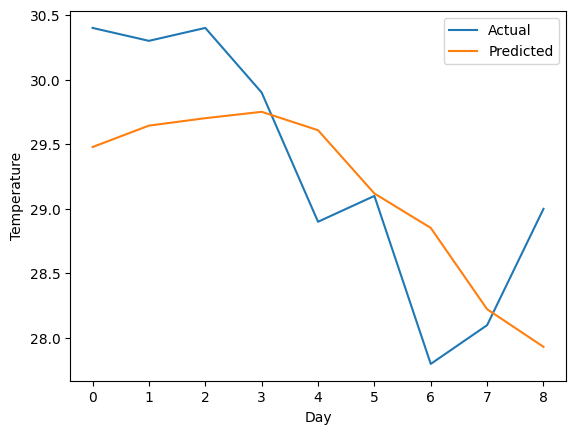

In [31]:
#Now plot both
plt.plot(new_y_val,label='Actual')
plt.plot(val_predictions,label='Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.legend()
plt.show()

In [32]:
present_df=pd.read_csv(r"C:\Users\sriva\Downloads\Bangalore,India last30days.csv")
present_df.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"Bangalore,India",2024-03-12,34.7,21.9,28.0,34.7,21.9,28.0,16.8,53.3,...,23.9,10,10,2024-03-12T06:28:51,2024-03-12T18:30:00,0.06,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"43296099999,VOBG,42705699999,VOBL,43302599999,..."
1,"Bangalore,India",2024-03-13,34.0,22.1,28.2,34.3,22.1,28.4,16.8,51.6,...,27.2,10,10,2024-03-13T06:28:13,2024-03-13T18:30:05,0.10,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"43296099999,VOBG,42705699999,VOBL,43302599999,..."
2,"Bangalore,India",2024-03-14,34.9,23.9,29.1,36.6,23.9,29.8,18.4,54.7,...,21.7,9,10,2024-03-14T06:27:35,2024-03-14T18:30:10,0.13,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"43296099999,VOBG,42705699999,VOBL,43302599999,..."
3,"Bangalore,India",2024-03-15,34.7,23.9,29.3,35.9,23.9,29.8,18.1,53.7,...,21.7,8,10,2024-03-15T06:26:56,2024-03-15T18:30:15,0.16,"Rain, Partially cloudy",Partly cloudy throughout the day with early mo...,rain,"43296099999,43272099999,VOBG,42705699999,VOBL,..."
4,"Bangalore,India",2024-03-16,34.9,23.9,28.8,35.5,23.9,29.3,18.0,54.1,...,26.8,10,10,2024-03-16T06:26:17,2024-03-16T18:30:20,0.20,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"43296099999,VOBG,42705699999,VOBL,43302599999,..."


In [33]:
required_columns=['datetime','temp']
input_df=dc(present_df[required_columns])
input_df['datetime']=pd.to_datetime(input_df['datetime'],format='%Y-%m-%d')
input_df.head()

,datetime,temp
0,2024-03-12,28.0
1,2024-03-13,28.2
2,2024-03-14,29.1
3,2024-03-15,29.3
4,2024-03-16,28.8


In [34]:
shifted_input=prep_df_lstm(input_df,time_period)
shifted_input.to_numpy()

array([[27.7, 28.8, 29.3, 29.1, 28.2, 28. ],
       [28.2, 27.7, 28.8, 29.3, 29.1, 28.2],
       [28.2, 28.2, 27.7, 28.8, 29.3, 29.1],
       [28. , 28.2, 28.2, 27.7, 28.8, 29.3],
       [26.7, 28. , 28.2, 28.2, 27.7, 28.8],
       [27.5, 26.7, 28. , 28.2, 28.2, 27.7],
       [28.2, 27.5, 26.7, 28. , 28.2, 28.2],
       [28.3, 28.2, 27.5, 26.7, 28. , 28.2],
       [27.9, 28.3, 28.2, 27.5, 26.7, 28. ],
       [28.1, 27.9, 28.3, 28.2, 27.5, 26.7],
       [27.9, 28.1, 27.9, 28.3, 28.2, 27.5],
       [29. , 27.9, 28.1, 27.9, 28.3, 28.2],
       [29.9, 29. , 27.9, 28.1, 27.9, 28.3],
       [29.3, 29.9, 29. , 27.9, 28.1, 27.9],
       [28.8, 29.3, 29.9, 29. , 27.9, 28.1],
       [29.5, 28.8, 29.3, 29.9, 29. , 27.9],
       [30.6, 29.5, 28.8, 29.3, 29.9, 29. ],
       [29.7, 30.6, 29.5, 28.8, 29.3, 29.9],
       [30.2, 29.7, 30.6, 29.5, 28.8, 29.3],
       [30.4, 30.2, 29.7, 30.6, 29.5, 28.8],
       [30.3, 30.4, 30.2, 29.7, 30.6, 29.5],
       [30.4, 30.3, 30.4, 30.2, 29.7, 30.6],
       [29

In [35]:
shifted_input=scaler.transform(shifted_input)
X_input=shifted_input[:,1:]
y_input=shifted_input[:,0]
X_input=dc(np.flip(X_input,axis=1))
X_input=X_input.reshape(-1,time_period,1)
y_input=y_input.reshape(-1,1)
X_input=torch.tensor(X_input).float().to(device)
y_input=torch.tensor(y_input).float().to(device)


c:\Users\sriva\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [36]:
#predict and check with the model made
with torch.no_grad():
    predicted_input=model(X_input).to('cpu').numpy()
dummies=np.zeros((X_input.to('cpu').shape[0],time_period+1))
dummies[:,0]=predicted_input.flatten()
dummies=scaler.inverse_transform(dummies)
input_predictions=dc(dummies[:,0])
input_predictions

array([28.52025292, 28.04298506, 27.90692667, 27.8569889 , 27.76389902,
       27.17764519, 27.14017305, 27.45455515, 27.70948039, 27.68628381,
       27.73667279, 27.67678107, 28.07286257, 28.69463388, 28.84508783,
       28.68527548, 28.81999187, 29.33142104, 29.34045002, 29.47830345,
       29.64404301, 29.70150815, 29.75082527, 29.60841608, 29.11880149,
       28.85247776])

In [37]:
#actual
dummies=np.zeros((X_input.to('cpu').shape[0],time_period+1))
dummies[:,0]=y_input.to('cpu').numpy().flatten()
dummies=scaler.inverse_transform(dummies)
new_y_input=dc(dummies[:,0])
new_y_input

array([27.69999982, 28.19999995, 28.19999995, 27.99999983, 26.69999992,
       27.50000006, 28.19999995, 28.29999983, 27.89999995, 28.10000007,
       27.89999995, 29.00000009, 29.90000011, 29.3000001 , 28.79999996,
       29.49999986, 30.6       , 29.69999998, 30.20000011, 30.39999987,
       30.29999999, 30.39999987, 29.90000011, 28.89999985, 29.09999997,
       27.80000007])

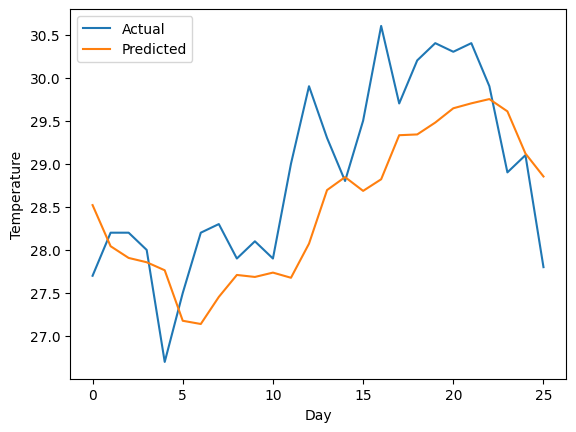

In [38]:
#plot
plt.plot(new_y_input,label='Actual')
plt.plot(input_predictions,label='Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.legend()
plt.show()

In [39]:
#predict for next 7 days using the model
'''
i=7
while(i>0):
    past_7days_day1=[shifted_input[-1][:10]]
    X_input=dc(np.flip(past_7days_day1,axis=1))
    X_input=X_input.reshape(1,-1,1)
    X_input=torch.tensor(X_input).float().to(device)
    with torch.no_grad():
        prediction=model(X_input).to('cpu').numpy().flatten()
    shifted_input=np.vstack((shifted_input,np.append(prediction,past_7days_day1)))
    i-=1
shifted_input=scaler.inverse_transform(shifted_input)'''

"\ni=7\nwhile(i>0):\n    past_7days_day1=[shifted_input[-1][:10]]\n    X_input=dc(np.flip(past_7days_day1,axis=1))\n    X_input=X_input.reshape(1,-1,1)\n    X_input=torch.tensor(X_input).float().to(device)\n    with torch.no_grad():\n        prediction=model(X_input).to('cpu').numpy().flatten()\n    shifted_input=np.vstack((shifted_input,np.append(prediction,past_7days_day1)))\n    i-=1\nshifted_input=scaler.inverse_transform(shifted_input)"

In [40]:
'''for i in range(-7,-1,1):
    print(shifted_input[i])'''

'for i in range(-7,-1,1):\n    print(shifted_input[i])'

In [41]:
'''predictions=[]
for i in range(7):
    predictions.append(shifted_input[-7+i][0])
predictions'''

'predictions=[]\nfor i in range(7):\n    predictions.append(shifted_input[-7+i][0])\npredictions'